In [1]:
import unicodedata
import string
import re
import random
import time
import datetime
import math
import socket
hostname = socket.gethostname()

import nltk
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
from masked_cross_entropy import *

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import io
import torchvision
from PIL import Image
import visdom
vis = visdom.Visdom()
%matplotlib inline

USE_CUDA = False

MIN_LENGTH = 5
MAX_LENGTH = 32

def sequence_mask(sequence_length, max_len=None):
    if max_len is None:
        max_len = sequence_length.data.max()
    batch_size = sequence_length.size(0)
    seq_range = torch.range(0, max_len - 1).long()
    seq_range_expand = seq_range.unsqueeze(0).expand(batch_size, max_len)
    seq_range_expand = Variable(seq_range_expand)
    if sequence_length.is_cuda:
        seq_range_expand = seq_range_expand.cuda()
    seq_length_expand = (sequence_length.unsqueeze(1)
                         .expand_as(seq_range_expand))
    return seq_range_expand < seq_length_expand


def masked_cross_entropy(logits, target, length):
    
    if USE_CUDA:
        length = Variable(torch.LongTensor(length)).cuda()
    else:
        length = Variable(torch.LongTensor(length))

    """
    Args:
        logits: A Variable containing a FloatTensor of size
            (batch, max_len, num_classes) which contains the
            unnormalized probability for each class.
        target: A Variable containing a LongTensor of size
            (batch, max_len) which contains the index of the true
            class for each corresponding step.
        length: A Variable containing a LongTensor of size (batch,)
            which contains the length of each data in a batch.
    Returns:
        loss: An average loss value masked by the length.
    """

    # logits_flat: (batch * max_len, num_classes)
    logits_flat = logits.view(-1, logits.size(-1))
    # log_probs_flat: (batch * max_len, num_classes)
    log_probs_flat = functional.log_softmax(logits_flat)
    # target_flat: (batch * max_len, 1)
    target_flat = target.view(-1, 1)
    # losses_flat: (batch * max_len, 1)
    losses_flat = -torch.gather(log_probs_flat, dim=1, index=target_flat)
    # losses: (batch, max_len)
    losses = losses_flat.view(*target.size())
    # mask: (batch, max_len)
    mask = sequence_mask(sequence_length=length, max_len=target.size(1))
    losses = losses * mask.float()
    loss = losses.sum() / length.float().sum()
    return loss

In [2]:
PAD_token = 0
SOS_token = 1
EOS_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS"}
        self.n_words = 3 # Count default tokens

    def index_words(self, sentence):
        for word in sentence.split(' '):
            self.index_word(word)

    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed: return
        self.trimmed = True
        
        keep_words = []
        
        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words %s / %s = %.4f' % (
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS"}
        self.n_words = 3 # Count default tokens

        for word in keep_words:
            self.index_word(word)

def normalize_string(s):
    s = re.sub(r"([,.!?])", r" \1 ", s)
    s = re.sub(r"[^a-zA-Z,.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s


def read_langs(lang1, lang2, term="txt", reverse=False, normalize=False):
    print("Reading lines...")

    # Read the file and split into lines

    # Attach the path here for the source and target language dataset
    #filename = '%s-%s.%s' % (lang1, lang2, term)
    
    # Short data:
    filename = "en-fr_short.bpe2bpe";
    
    # This creats the file directory name whichis used below

    # lines contains the data in form of a list 
    lines = open(filename, encoding="utf8").read().strip().split('\n')

    # Split every line into pairs and normalize
    if normalize == True:
        pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]
    else: 
        pairs = [[s for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs


def filter_pairs(pairs, MIN_LENGTH, MAX_LENGTH):
    filtered_pairs = []
    for pair in pairs:
        if len(pair[0]) >= MIN_LENGTH and len(pair[0]) <= MAX_LENGTH \
            and len(pair[1]) >= MIN_LENGTH and len(pair[1]) <= MAX_LENGTH:
                filtered_pairs.append(pair)
    return filtered_pairs


In [3]:
def prepare_data(lang1_name, lang2_name, reverse=False):

    # Get the source and target language class objects and the pairs (x_t, y_t)
    
    ## 1. normalize in argument ????
    input_lang, output_lang, pairs = read_langs(lang1_name, lang2_name, "bpe2bpe",reverse, False)
    print("Read %d sentence pairs" % len(pairs))
    
    ## 2. MIN LENGTH & MAX LENGTH ????
    pairs = filter_pairs(pairs, MIN_LENGTH, MAX_LENGTH)
    print("Filtered to %d pairs" % len(pairs))
    
    print("Indexing words...")
    for pair in pairs:
        input_lang.index_words(pair[0])
        output_lang.index_words(pair[1])
    
    print('Indexed %d words in input language, %d words in output' % (input_lang.n_words, output_lang.n_words))
    return input_lang, output_lang, pairs


# Return a list of indexes, one for each word in the sentence, plus EOS
def indexes_from_sentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')] + [EOS_token]

# Pad a with the PAD symbol
def pad_seq(seq, max_length):
    seq += [PAD_token for i in range(max_length - len(seq))]
    return seq


def random_batch(batch_size):
    input_seqs = []
    target_seqs = []

    # Choose random pairs
    for i in range(batch_size):
        pair = random.choice(pairs)
        input_seqs.append(indexes_from_sentence(input_lang, pair[0]))
        target_seqs.append(indexes_from_sentence(output_lang, pair[1]))

    # Zip into pairs, sort by length (descending), unzip
    seq_pairs = sorted(zip(input_seqs, target_seqs), key=lambda p: len(p[0]), reverse=True)
    input_seqs, target_seqs = zip(*seq_pairs)
    
    # For input and target sequences, get array of lengths and pad with 0s to max length
    input_lengths = [len(s) for s in input_seqs]
    input_padded = [pad_seq(s, max(input_lengths)) for s in input_seqs]
    target_lengths = [len(s) for s in target_seqs]
    target_padded = [pad_seq(s, max(target_lengths)) for s in target_seqs]

    # Turn padded arrays into (batch_size x max_len) tensors, transpose into (max_len x batch_size)
    input_var = Variable(torch.LongTensor(input_padded)).transpose(0, 1)
    target_var = Variable(torch.LongTensor(target_padded)).transpose(0, 1)
    
    if USE_CUDA:
        input_var = input_var.cuda()
        target_var = target_var.cuda()
        
    return input_var, input_lengths, target_var, target_lengths


In [4]:
input_lang, output_lang, pairs = prepare_data('en', 'fr', False)

# TRIMMING DATA:
# Trimming is optional but could be done to reduce the data size and make processing faster
# Removes words with frequency < 5

MIN_COUNT = 5

input_lang.trim(MIN_COUNT)
output_lang.trim(MIN_COUNT)


keep_pairs = []

for pair in pairs:
    input_sentence = pair[0]
    output_sentence = pair[1]
    keep_input = True
    keep_output = True

    for word in input_sentence.split(' '):
        if word not in input_lang.word2index:
            keep_input = False
            break

    for word in output_sentence.split(' '):
        if word not in output_lang.word2index:
            keep_output = False
            break

    # Remove if pair doesn't match input and output conditions
    if keep_input and keep_output:
        keep_pairs.append(pair)

print("Trimmed from %d pairs to %d, %.4f of total" % (len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
pairs = keep_pairs

Reading lines...
Read 25000 sentence pairs
Filtered to 1182 pairs
Indexing words...
Indexed 1342 words in input language, 1506 words in output
keep_words 152 / 1339 = 0.1135
keep_words 155 / 1503 = 0.1031
Trimmed from 1182 pairs to 227, 0.1920 of total


In [5]:
len(pairs)

227

In [6]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, dropout=0.1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size #no of words in the input Language
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=self.dropout, bidirectional=True)
        
        
    def forward(self, input_seqs, input_lengths, hidden=None): # hidden vector starts with zero (a guess!)
        
        # Note: we run this all at once (over multiple batches of multiple sequences)
        embedded = self.embedding(input_seqs) # size = (max_length, batch_size, embed_size). NOTE: embed_size = hidden size here
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths) # size = (max_length * batch_size, embed_size)
        
        outputs, hidden = self.gru(packed, hidden) # outputs are supposed to be probability distribution right?
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:] # Sum bidirectional outputs
        return outputs, hidden

    #output (seq_len, batch, hidden_size * num_directions): tensor containing the output features h_t from the last layer of the 
    # RNN, for each t. If a torch.nn.utils.rnn.PackedSequence has been given as the input, the output will also be a packed sequence.
    
    # h_n (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t=seq_len
    
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        max_len = encoder_outputs.size(0)
        this_batch_size = encoder_outputs.size(1)

        # Create variable to store attention energies
        attn_energies = Variable(torch.zeros(this_batch_size, max_len)) # B x S

        if USE_CUDA:
            attn_energies = attn_energies.cuda()

        # For each batch of encoder outputs
        for b in range(this_batch_size):
            # Calculate energy for each encoder output
            for i in range(max_len):
                #attn_energies[b, i] = self.score(hidden[:, b], encoder_outputs[i, b].unsqueeze(0))
                attn_energies[b, i] = self.score(hidden[b,:], encoder_outputs[i, b])

        # Normalize energies to weights in range 0 to 1, resize to 1 x B x S
        return F.softmax(attn_energies).unsqueeze(1)
    
    def score(self, hidden, encoder_output):
        
        if self.method == 'dot':
            energy = hidden.dot(encoder_output)
            return energy
        
        elif self.method == 'general':
            energy = self.attn(encoder_output)
            energy = hidden.dot(energy)
            return energy
        
        elif self.method == 'concat':
            #print(torch.cat((hidden, encoder_output), 1), attn)
            energy = self.attn(torch.cat((hidden, encoder_output), 0))
            #energy = self.v.dot(energy)
            #print(self.v.squeeze(0), energy)
            energy = (self.v.squeeze(0)).dot(energy)
            return energy
        
##############################################################################################
#########################  BAHDANAU_ATTN_DECODER_RNN  ########################################
##############################################################################################
        
class BahdanauAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(BahdanauAttnDecoderRNN, self).__init__()
        
        # Define parameters
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        ## 3. self.max_length = max_length
        self.max_length = MAX_LENGTH
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.attn = Attn('concat', hidden_size)
        
        # Modifications made below in 2 lines
        self.gru = nn.GRU(2*hidden_size, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size * 2, output_size) # use of linear layer ?
    
    def forward(self, word_input, last_hidden, encoder_outputs):
        # Note: we run this one step at a time
        # TODO: FIX BATCHING
        
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, word_input.data.shape[0], -1) # S=1 x B x N , ## N = hidden size (doubt)
        #print(word_embedded.size())
        word_embedded = self.dropout(word_embedded)
        
        # Calculate attention weights and apply to encoder outputs
        attn_weights = self.attn(last_hidden[-1], encoder_outputs)
        #print(attn_weights.size())
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        context = context.transpose(0, 1) # 1 x B x N
        #print(context.size(), word_embedded.size(), self.output_size)
        
        # Combine embedded input word and attended context, run through RNN
        rnn_input = torch.cat((word_embedded, context), 2) # 1 x B x 2N (There seems to be a mistake here)
        output, hidden = self.gru(rnn_input, last_hidden)

        # Final output layer
        output = output.squeeze(0) # B x N
        
        ## Modification made below too
        #output = F.log_softmax(self.out(torch.cat((output, context), 1)))
        output = F.log_softmax(self.out(torch.cat((output, context.squeeze(0)), 1)))
        
        # Return final output, hidden state, and attention weights (for visualization)
        
        # print(self.output.size(), output.size(), hidden.size(), attn_weights.size())
        # 330, torch.Size([80, 330]) torch.Size([2, 80, 1024]) torch.Size([80, 1, 10])
        return output, hidden, attn_weights


In [7]:
rr = '1-2-3'
rr.split("-")[-1] if len(rr) > 1 else rr

'3'

In [8]:
# BEAM SEARCH:
    # A dictinary is maintained which keeps track of the sequence within top first k probabilities
    # If k = 1, it is same as greedy search. 
    # The dictinary is of the form {sequence: [probability, decoder_hidden, decoder_attention] }
    # The dictinary data type is  {string: [int, torch.Size([num_directions, batch_size, hidden_size]), torch.Size([max_length+1, max_length+1])]}


def update_dictionary(target_sequence, topv, topi, key, dec_hidden, decoder_attns):
    if len(target_sequence) == 0:
        for i in range(len(topi)):
            target_sequence.update({str(topi[i]) : [topv[i], dec_hidden, decoder_attns] })
    else:
        prev_val = target_sequence[key][0]
        for i in range(len(topi)):
            target_sequence.update({key+"-"+str(topi[i]) : [topv[i]*prev_val, dec_hidden, decoder_attns] })
        del[target_sequence[key]]
        

def get_seq_through_beam_search(max_length, decoder, decoder_input, decoder_hidden, decoder_attentions, encoder_outputs, kmax ):
    
    target_sequence = dict()
    
    # Run through decoder
    for di in range(max_length):
        
        if di == 0:
            decoder_output, decoder_hidden, decoder_attention = decoder( decoder_input, decoder_hidden, encoder_outputs )
            topv, topi = decoder_output.data.topk(kmax)
            topv = topv[0].numpy()
            topi = topi[0].numpy()
            decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data
            update_dictionary(target_sequence, topv, topi, None, decoder_hidden, decoder_attentions)
        else:
            temp = target_sequence.copy()
            keys = list(temp.keys())
            for i in range(len(keys)):
                inp = int(keys[i].split("-")[-1] if len(keys[i]) > 1 else keys[i])
                if inp != EOS_token:
                    dec_input = Variable(torch.LongTensor([inp]))
                    decoder_output, dec_hidden, decoder_attention = decoder( dec_input, temp[keys[i]][1], encoder_outputs )
                    topv, topi = decoder_output.data.topk(kmax)
                    topv = topv[0].numpy()
                    topi = topi[0].numpy()
                    dec_attns = temp[keys[i]][2]
                    dec_attns[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data
                    update_dictionary(target_sequence, topv, topi, keys[i], dec_hidden, dec_attns)
        
        # Sort the target_Sequence dictionary and keep top k sequences only
        target_sequence = dict(sorted(target_sequence.items(), key=lambda x: x[1][0], reverse=True)[:kmax])
     
    # Get the sequence, decoder_attentions with maximum probability
    pair = sorted(target_sequence.items(), key=lambda x: x[1][0], reverse=True)[:1][0]
    seq = pair[0]
    decoder_attentions = pair[1][2]
    
    # Get the decoded words:
    decoded_words_indices = seq.split("-")
    decoded_words = [output_lang.index2word[int(i)] for i in decoded_words_indices]
    if int(decoded_words_indices[-1]) != EOS_token:
        decoded_words.append('<EOS>')
    
    return decoded_words, decoder_attentions

In [9]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

# Evaluation is mostly the same as training, but there are no targets. Instead we always feed the decoder's predictions back to itself. 
# Every time it predicts a word, we add it to the output string. If it predicts the EOS token we stop there. We also store the decoder's attention outputs for each step to display later.

def evaluate(input_seq, max_length=MAX_LENGTH):
    input_lengths = [len(input_seq)]
    input_seqs = [indexes_from_sentence(input_lang, input_seq)]
    input_batches = Variable(torch.LongTensor(input_seqs), volatile=True).transpose(0, 1)
    
    if USE_CUDA:
        input_batches = input_batches.cuda()
        
    # Set to not-training mode to disable dropout
    encoder.train(False)
    decoder.train(False)
    
    # Run through encoder
    encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)

    # Create starting vectors for decoder
    decoder_input = Variable(torch.LongTensor([SOS_token]), volatile=True) # SOS
    decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder
    # size for decoder_hidden = (B, H)
    
    if USE_CUDA:
        decoder_input = decoder_input.cuda()

    # Store output words and attention states
    decoder_attentions = torch.zeros(max_length + 1, max_length + 1)
    # print(decoder_input.size(), decoder_hidden.size(), encoder_outputs.size())
    kmax = 10
    decoded_words, decoder_attentions = get_seq_through_beam_search(max_length, decoder, decoder_input, decoder_hidden, decoder_attentions, encoder_outputs, kmax )

    #decoded_words, decoder_attentions = get_seq_through_beam_search(len(input_seq), decoder, decoder_input, decoder_hidden, decoder_attentions, encoder_outputs, kmax )

    # Set back to training mode
    encoder.train(True)
    decoder.train(True)
    
    return decoded_words, decoder_attentions[:len(decoded_words)+1, :len(encoder_outputs)]


# We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements:
def evaluate_randomly():
    [input_sentence, target_sentence] = random.choice(pairs)
    evaluate_and_show_attention(input_sentence, target_sentence)

def show_plot_visdom():
    buf = io.BytesIO()
    plt.savefig(buf)
    buf.seek(0)
    attn_win = 'attention (%s)' % hostname
    vis.image(torchvision.transforms.ToTensor()(Image.open(buf)), win=attn_win, opts={'title': attn_win})

def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    show_plot_visdom()
    plt.show()
    plt.close()

def evaluate_and_show_attention(input_sentence, target_sentence=None):
    output_words, attentions = evaluate(input_sentence)
    
    # Calculating the bleu score excluding the last word (<EOS>)
    #bleu_score = nltk.translate.bleu_score.sentence_bleu([target_sentence], ' '.join(output_words[:-1]))
    
    output_sentence = ' '.join(output_words)
    
    print('>', input_sentence)
    if target_sentence is not None:
        print('=', target_sentence)
    print('<', output_sentence)
    #print("BLUE SCORE IS:", bleu_score)
    
    show_attention(input_sentence, output_words, attentions)
    
    # Show input, target, output text in visdom
    win = 'evaluted (%s)' % hostname
    text = '<p>&gt; %s</p><p>= %s</p><p>&lt; %s</p>' % (input_sentence, target_sentence, output_sentence)
    vis.text(text, win=win, opts={'title': win})

In [10]:
def train(input_batches, input_lengths, target_batches, target_lengths, encoder, decoder, encoder_optimizer, decoder_optimizer, max_length=MAX_LENGTH):
    
    # Added 2 lines below
    encoder.train(True)
    decoder.train(True)
    
    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Run words through encoder
    encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)

    # Prepare input and output variables
    decoder_input = Variable(torch.LongTensor([SOS_token] * batch_size))
    
    # Q.) Why do we use the last hidden state for t = 0. is of because z_t = phi_init(context_vector)
    decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder

    max_target_length = max(target_lengths)
    all_decoder_outputs = Variable(torch.zeros(max_target_length, batch_size, decoder.output_size))

    # Move new Variables to CUDA
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        all_decoder_outputs = all_decoder_outputs.cuda()

    # Run through decoder one time step at a time
    for t in range(max_target_length):
        decoder_output, decoder_hidden, decoder_attn = decoder(
            decoder_input, decoder_hidden, encoder_outputs
        )

        all_decoder_outputs[t] = decoder_output
        decoder_input = target_batches[t] # Next input is current target

    # Loss calculation and backpropagation
    loss = masked_cross_entropy(
        all_decoder_outputs.transpose(0, 1).contiguous(), # -> batch x seq
        target_batches.transpose(0, 1).contiguous(), # -> batch x seq
        target_lengths
    )
    loss.backward()
    
    # Clip gradient norms
    ec = torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
    dc = torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)

    # Update parameters with optimizers
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0], ec, dc

Starting job 5a1cb649bb92582e4f253cea at 2017-11-27 20:05:12


C:\Users\akash\Anaconda3\lib\site-packages\ipykernel\__main__.py:39: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.3. Note that arange generates values in [start; end), not [start; end].


[log] 2m 17s (2) 3.9746
2m 17s (- 14m 55s) (2 13%) 4.5133
> Thank you very much .
= Merci beaucoup .
< Et , EOS


OSError: cannot write mode RGBA as JPEG

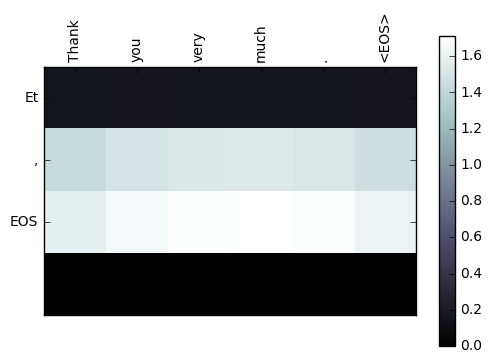

In [11]:
# Configure models
# attn_model = 'dot'
hidden_size = 1024
n_layers = 2
dropout = 0.1
batch_size = 80
# batch_size = 50

# Configure training/optimization
clip = 50.0
#clip = 1.0 # Based on our paper, clipping gradient norm is 1
teacher_forcing_ratio = 0.5
learning_rate = 0.0001
decoder_learning_ratio = 5.0
#n_epochs = 50000
n_epochs = 15
epoch = 0
#plot_every = 20
#print_every = 100
#evaluate_every = 10000 # We check the validation in every 10,000 minibatches

plot_every = 2
print_every = 2
evaluate_every = 2 # We check the validation in every 10,000 minibatches


# Initialize models
encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers, dropout=dropout)
decoder = BahdanauAttnDecoderRNN( hidden_size, output_lang.n_words, n_layers, dropout_p=dropout)

# Initialize optimizers and criterion
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
criterion = nn.CrossEntropyLoss()

# Move models to GPU
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

import sconce
job = sconce.Job('seq2seq-translate', {
    #'attn_model': attn_model,
    'n_layers': n_layers,
    'dropout': dropout,
    'hidden_size': hidden_size,
    'learning_rate': learning_rate,
    'clip': clip,
    'teacher_forcing_ratio': teacher_forcing_ratio,
    'decoder_learning_ratio': decoder_learning_ratio,
})
job.plot_every = plot_every
job.log_every = print_every

# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every


##########################################################################
######                         PART-III : Modeling                   #####
##########################################################################

ecs = []
dcs = []
eca = 0
dca = 0

while epoch < n_epochs:
    epoch += 1

    # Get training data for this cycle
    input_batches, input_lengths, target_batches, target_lengths = random_batch(batch_size)
    #print(input_batches.size())
    
    # Run the train function
    loss, ec, dc = train(
        input_batches, input_lengths, target_batches, target_lengths,
        encoder, decoder,
        encoder_optimizer, decoder_optimizer)
    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss
    eca += ec
    dca += dc

    job.record(epoch, loss)

    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)

    if epoch % evaluate_every == 0:
        evaluate_randomly()

    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

        # TODO: Running average helper
        ecs.append(eca / plot_every)
        dcs.append(dca / plot_every)
        ecs_win = 'encoder grad (%s)' % hostname
        dcs_win = 'decoder grad (%s)' % hostname
        vis.line(np.array(ecs), win=ecs_win, opts={'title': ecs_win})
        vis.line(np.array(dcs), win=dcs_win, opts={'title': dcs_win})
        eca = 0
        dca = 0